# BM 336546 - HW2
# Part I: Data Exploration
# 1- Data loading

In T1D all the data were saved, then we will separate between the diagnosis "Diagnosis" and the features "T1D_features".  

In [131]:
# Loading Data

import sys
import pandas as pd 
import numpy as np
from pathlib import Path
import random
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import hinge_loss
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
# from sklearn.metrics import plot_confusion_matrix, roc_auc_score,plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
%load_ext autoreload


T1D_dataset = pd.read_csv("HW2_data.csv") 
T1D = T1D_dataset[['Age','Gender','Increased Urination','Increased Thirst','Sudden Weight Loss','Weakness','Increased Hunger',
                            'Genital Thrush','Visual Blurring','Itching','Irritability','Delayed Healing','Partial Paresis',
                            'Muscle Stiffness','Hair Loss','Obesity','Family History']]
Diagnosis = T1D_dataset[['Diagnosis']]

random.seed(10)  # fill your seed number here
T1D_features=T1D.copy()
T1D.sample(n=5, random_state=5)#Display data of five random patient 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Age,Gender,Increased Urination,Increased Thirst,Sudden Weight Loss,Weakness,Increased Hunger,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Hair Loss,Obesity,Family History
197,62,Male,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,Yes,No,Yes,No,0
330,40,Male,No,No,Yes,No,No,No,No,No,No,No,No,No,No,Yes,1
261,30,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0
336,30,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,1
539,67,Male,No,No,No,No,NaN,No,Yes,NaN,No,No,No,NaN,No,No,0


After loading the Data and expecting the information of five random patient, we need to handle 
the missing data using random sampling of each series values. We used np.random.choice to 
specify each replacing-values' probability, so that the random sampling will be derived from
the same distribution as the original valid series data.


In [132]:
# replacing nans with samples

i=T1D_features.columns.values

T1Dc_features={}    
for x in i:
    Q = T1D_features[x]
    null_ind=np.where(Q.isnull())[0]
   
    for ii in null_ind:
        Q.iloc[ii] = Q.iloc[np.random.choice(np.where(Q.notnull())[0])]
    T1Dc_features[x] = Q
    

T1Dc_features=pd.DataFrame(T1Dc_features)
T1Dc_features.sample(n=5, random_state=5)

C:\ANACONDA\envs\bm-336546\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Age,Gender,Increased Urination,Increased Thirst,Sudden Weight Loss,Weakness,Increased Hunger,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Hair Loss,Obesity,Family History
197,62,Male,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,Yes,No,Yes,No,0
330,40,Male,No,No,Yes,No,No,No,No,No,No,No,No,No,No,Yes,1
261,30,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0
336,30,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,1
539,67,Male,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,0


Now that we filled the missing data, we will work with the "T1Dc_features".
Lets make sure that the missing data were filled.
Pick a feature that you know for sure that it had some missing data, and look at it's values before and after. We can see that the preprocessing was fulfilled.


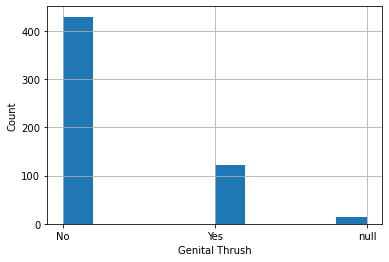

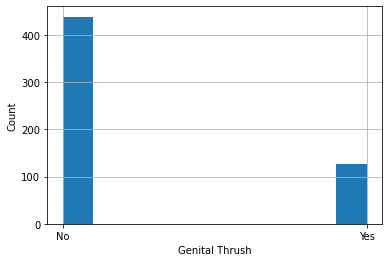

In [133]:
# Make sure that we have no Null values left
feat = 'Genital Thrush' #pick a feature
Q = pd.DataFrame(T1D[feat])

idx_na = Q.index[Q[feat].isnull()].tolist()

for i in idx_na:
    Q.loc[idx_na] = "null"

Q[feat].hist(bins = 10)
plt.xlabel('Genital Thrush')
plt.ylabel('Count')
plt.show()

T1Dc_features[feat].hist(bins = 10)
plt.xlabel('Genital Thrush')
plt.ylabel('Count')
plt.show()

In [134]:
# axarr = T1Dc_features.hist(bins=50, figsize=(20, 15)) # histograms of dataframe variables
# for idx, ax in enumerate(axarr.flatten()):
# #     ax.set_xlabel(i[idx])
#     ax.set_ylabel("Count")
# plt.show()

Section 2: test-train split of 20% test

In [135]:
#test-train split

orig_feat = T1Dc_features.columns.values
X_train, X_test, y_train, y_test = train_test_split(T1Dc_features, np.ravel(Diagnosis), test_size=0.2, random_state=0, stratify=np.ravel(Diagnosis))


Section 3: Detailed visualization and exploration of the data.

3a- Look at the distribution of the features, we can see that it is similar 
between test and train, and the differences are not significant.    

In [136]:
#3-a
tbl1=[]
tbl1={'Train %':((X_train.iloc[:,1:]=='Yes') | 
                 (X_train.iloc[:,1:]=='Male') | (X_train.iloc[:,1:]==1))
      .sum()*100/len(X_train)}
tbl1['Test %']=((X_test.iloc[:,1:]=='Yes') | (X_test.iloc[:,1:]=='Male') 
                | (X_test.iloc[:,1:]==1)).sum()*100/len(X_test)
tbl1['Delta %']=tbl1['Train %']-tbl1['Test %']
print(pd.DataFrame(tbl1))

                       Train %     Test %   Delta %
Gender               63.938053  62.831858  1.106195
Increased Urination  48.230088  48.672566 -0.442478
Increased Thirst     45.353982  40.707965  4.646018
Sudden Weight Loss   40.044248  45.132743 -5.088496
Weakness             56.415929  60.176991 -3.761062
Increased Hunger     45.132743  42.477876  2.654867
Genital Thrush       21.460177  26.548673 -5.088496
Visual Blurring      45.796460  41.592920  4.203540
Itching              49.115044  44.247788  4.867257
Irritability         23.008850  25.663717 -2.654867
Delayed Healing      46.902655  43.362832  3.539823
Partial Paresis      42.699115  42.477876  0.221239
Muscle Stiffness     36.946903  37.168142 -0.221239
Hair Loss            34.292035  41.592920 -7.300885
Obesity              17.477876  14.159292  3.318584
Family History       50.221239  52.212389 -1.991150


As for the "Age" feature, we made sure that tha train and the test have 
the same distribution by plotting a histogram of it's values. And we can see that they have 
approximately the same distribution.

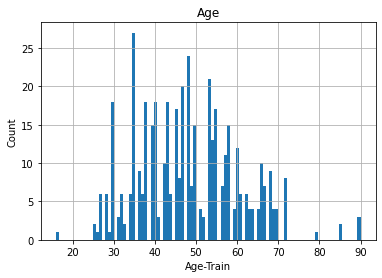

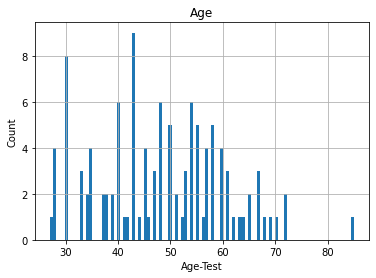

In [137]:
#compare Age distribution
feat = 'Age'
Q=X_train[[feat]]
Q.hist(bins = 100)

plt.xlabel('Age-Train')
plt.ylabel('Count')
plt.show()

q=X_test[['Age']]
q.hist(bins = 100)

plt.xlabel('Age-Test')
plt.ylabel('Count')
plt.show()

3a-i- An imbalance of features between train and test could lead to poorly training the model, which will lead to poor classification of the data. And that might impair sensitivity and pecificity of the model, because the classifier will predict the wrong diagnosis of the test data.  

3a-ii- If the feature with the an imbalance is not so important, and does not contribute

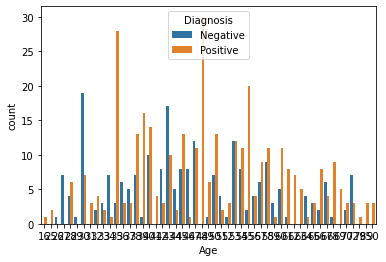

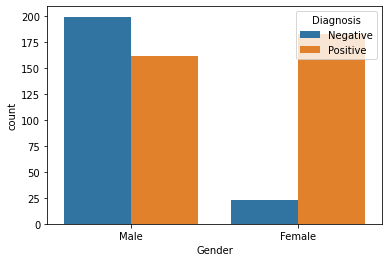

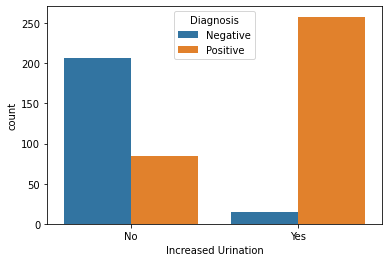

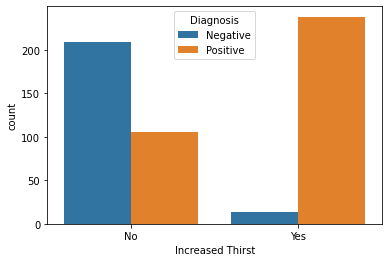

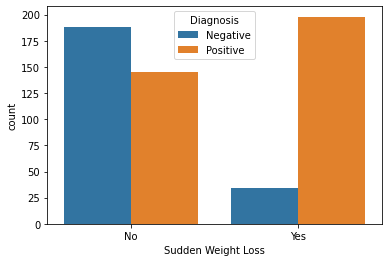

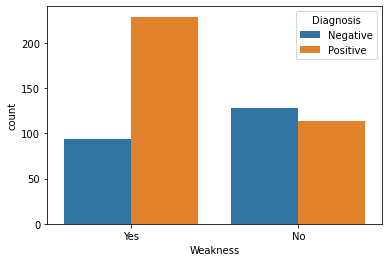

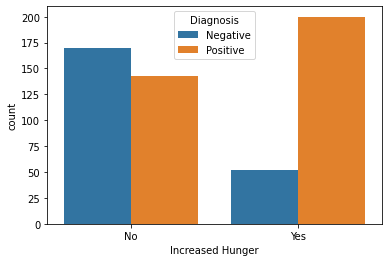

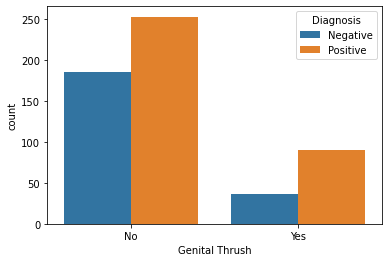

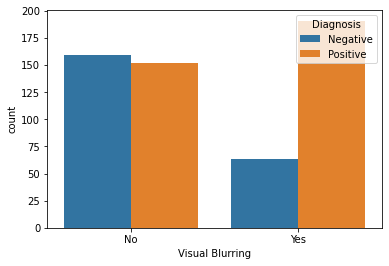

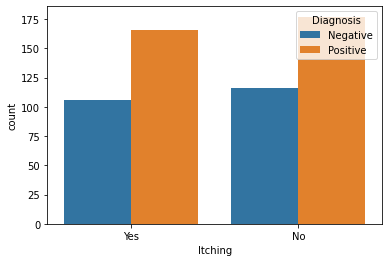

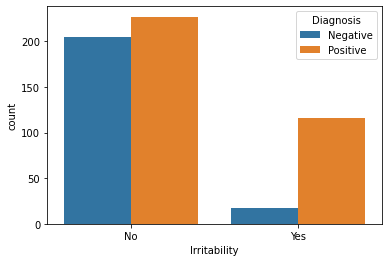

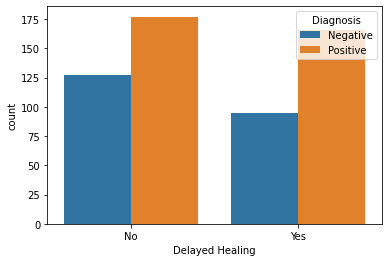

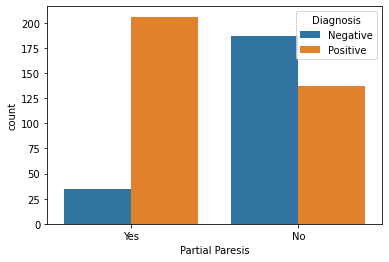

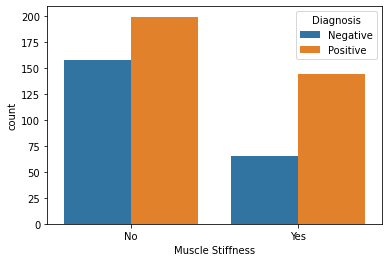

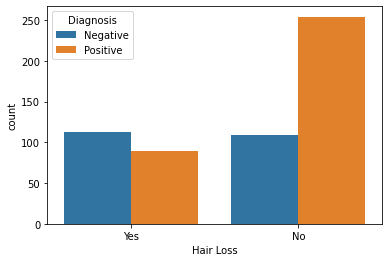

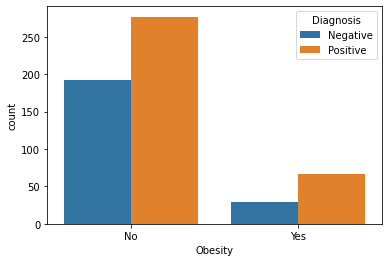

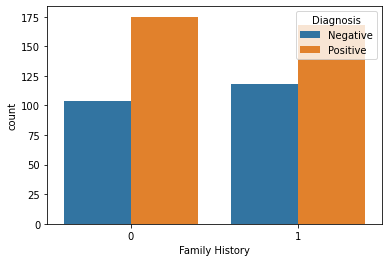

In [138]:
#3-b: relationship between feature and label

data_plotting=T1Dc_features.copy()
data_plotting['Diagnosis']=Diagnosis
features = T1Dc_features.columns.values
for feat in features:
    ax = sns.countplot(x=feat, hue="Diagnosis", data=data_plotting) 
   
    plt.show()
    

<AxesSubplot:>

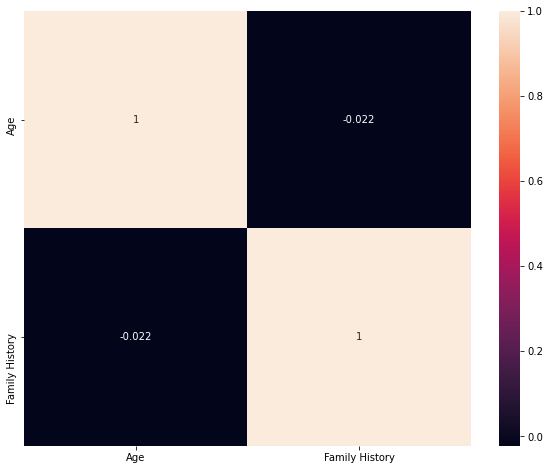

In [139]:
# #3-cIT HAS TO BE NUMERIC
plt.figure(figsize = (10,8))
sns.heatmap(T1Dc_features.corr(), annot = True)

In [140]:
#Section 4 - Hot Vector
# hot_vector=data_plotting.copy()
# hot_vector['Diagnosis']=pd.get_dummies(data=hot_vector['Diagnosis'],drop_first=True)
# del hot_vector['Age']
# print(hot_vector)
X_train = pd.get_dummies(data=X_train, drop_first=True)
X_test = pd.get_dummies(data=X_test, drop_first=True)
y_train = np.ravel(pd.get_dummies(data=y_train, drop_first=True))
y_test = np.ravel(pd.get_dummies(data=y_test, drop_first=True))


In [141]:
def plot_radar(clf, clf_type):
    labels=np.array(['Accuracy', 'F1', 'PPV', 'Sensitivity', 'AUROC']) 
    score_mat_train = np.stack((clf.cv_results_['mean_train_accuracy'], clf.cv_results_['mean_train_f1'],
                               clf.cv_results_['mean_train_precision'], clf.cv_results_['mean_train_recall'],
                               clf.cv_results_['mean_train_roc_auc']), axis=0)
    score_mat_val = np.stack((clf.cv_results_['mean_test_accuracy'], clf.cv_results_['mean_test_f1'],
                               clf.cv_results_['mean_test_precision'], clf.cv_results_['mean_test_recall'],
                               clf.cv_results_['mean_test_roc_auc']), axis=0)


    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)

    angles=np.concatenate((angles,[angles[0]]))
    cv_dict = clf.cv_results_['params']
    fig=plt.figure(figsize=(18,14))
    if 'svm__gamma' in cv_dict[0]:
        new_list = [(i, item) for i, item in enumerate(cv_dict) if
                    item["svm__kernel"] == clf_type[0] and item["svm__gamma"] == clf_type[1]]
    else:
        new_list = [(i, item) for i, item in enumerate(cv_dict) if
                    item["svm__kernel"] == clf_type[0]]
    for idx, val in enumerate(new_list):
        ax = fig.add_subplot(1, len(new_list), 1+idx, polar=True)
        rel_idx, rel_dict = val
        stats_train = score_mat_train[:, rel_idx]
        stats_train=np.concatenate((stats_train,[stats_train[0]]))
        ax.plot(angles, stats_train, 'o-', linewidth=2)
        ax.fill(angles, stats_train, alpha=0.25)
        stats_val = score_mat_val[:, rel_idx]
        stats_val=np.concatenate((stats_val,[stats_val[0]]))
        ax.plot(angles, stats_val, 'o-', linewidth=2)
        ax.fill(angles, stats_val, alpha=0.25)
        ax.set_thetagrids(angles[0:-1] * 180/np.pi, labels)
        if idx == 0:
            ax.set_ylabel(clf_type[0], fontsize=18)
        ax.set_title('C = %.3f' % (rel_dict['svm__C']))
        if 'svm__gamma' in cv_dict[0]:
            ax.set_xlabel('$\gamma = %s $' % (rel_dict['svm__gamma']))
        ax.set_ylim([0,1])
        ax.legend(['Train','Validation'])
        ax.grid(True)
        
    plt.show()

In [142]:
#Linear section 5
#K-fold
n_splits = 5 #5k cross fold
skf = StratifiedKFold(n_splits=n_splits, random_state=10, shuffle=True)
svc = SVC(probability=True)

In [143]:
def SVM_lin_model(X_train, y_train):
    C = np.array([0.001, 0.01, 1, 10, 100, 1000])
    pipe = Pipeline(steps=[('scale', StandardScaler()), ('svm', svc)])
    svm_lin = GridSearchCV(estimator=pipe, param_grid={'svm__C': C, 'svm__kernel': ['linear']},cv=skf,
                       scoring=['accuracy','f1','precision','recall','roc_auc'], 
                      refit='roc_auc', verbose=3, return_train_score=True)
    svm_lin.fit(X_train, y_train)
    return svm_lin
    
#     C = np.array([0.001, 0.01, 1, 10, 100, 1000])
# pipe = Pipeline(steps=[('scale', StandardScaler()), ('svm', svc)])
# svm_lin = GridSearchCV(estimator=pipe, param_grid={'svm__C': C, 'svm__kernel': ['linear']},cv=skf,
#                        scoring=['accuracy','f1','precision','recall','roc_auc'], 
#                        refit='roc_auc', verbose=3, return_train_score=True)
# svm_lin.fit(X_train, y_train)
def SVM_nonlin_model(X_train, y_train):
    C = np.array([1, 100, 1000])#, 10, 100, 1000])
    pipe = Pipeline(steps=[('scale', StandardScaler()), ('svm', svc)])
    svm_nonlin = GridSearchCV(estimator=pipe, param_grid={'svm__C': C, 'svm__kernel': ['rbf', 'poly'],
                                                      'svm__gamma': ['auto', 'scale']},
                       scoring=['accuracy','f1','precision','recall','roc_auc'], cv=skf,
                       refit='roc_auc', verbose=3, return_train_score=True)
    svm_nonlin.fit(X_train, y_train)
    return svm_nonlin

In [144]:
# Model 1 - SVM
svm_lin = SVM_lin_model(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END svm__C=0.001, svm__kernel=linear; accuracy: (train=0.875, test=0.824) f1: (train=0.903, test=0.864) precision: (train=0.857, test=0.810) recall: (train=0.954, test=0.927) roc_auc: (train=0.951, test=0.917) total time=   0.0s
[CV 2/5] END svm__C=0.001, svm__kernel=linear; accuracy: (train=0.820, test=0.846) f1: (train=0.867, test=0.885) precision: (train=0.787, test=0.806) recall: (train=0.963, test=0.982) roc_auc: (train=0.952, test=0.973) total time=   0.0s
[CV 3/5] END svm__C=0.001, svm__kernel=linear; accuracy: (train=0.867, test=0.800) f1: (train=0.897, test=0.845) precision: (train=0.850, test=0.790) recall: (train=0.950, test=0.907) roc_auc: (train=0.956, test=0.918) total time=   0.0s
[CV 4/5] END svm__C=0.001, svm__kernel=linear; accuracy: (train=0.820, test=0.822) f1: (train=0.868, test=0.869) precision: (train=0.783, test=0.791) recall: (train=0.973, test=0.964) roc_auc: (train=0.953, test=0.959) total t

In [145]:
best_svm_lin = svm_lin.best_estimator_
print(svm_lin.best_params_)

{'svm__C': 1000.0, 'svm__kernel': 'linear'}


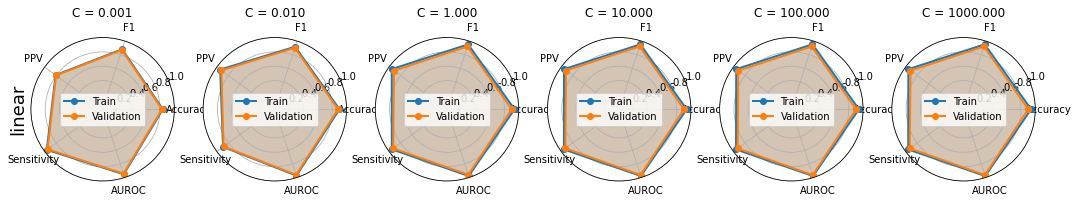

In [146]:
#compare C's
clf_type = ['linear']
plot_radar(svm_lin,clf_type)

6/6 lambda values, processed folds: 100%|████████████████████████████████████████████████| 5/5 [00:00<00:00, 68.67it/s]


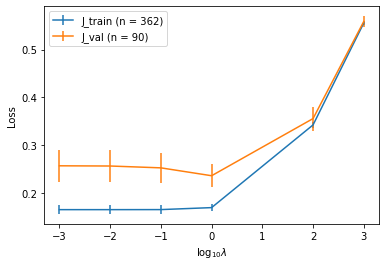

In [147]:
#Linear model 2 - logistic
pen = 'l2'
CC = np.array([0.001, 0.01, 1, 10, 100, 1000]) #1/lambda
scaler = StandardScaler()

J_train = np.zeros((2,len(CC)))
J_val = np.zeros((2,len(CC)))

for idx, C in enumerate(CC):
    
    #--------------------------Impelment your code here:-------------------------------------
    log_reg = LogisticRegression(random_state=5, penalty='l2', C = C, max_iter=2000,solver='lbfgs')
    #----------------------------------------------------------------------------------------
    with tqdm(total=n_splits, file=sys.stdout, position=0, leave=True) as pbar:
        h = 0 # index per split per lambda
        J_train_fold = np.zeros(n_splits)
        J_val_fold = np.zeros(n_splits)

        for train_index, val_index in skf.split(X_train, y_train):
            pbar.set_description('%d/%d lambda values, processed folds' % ((1 + idx), len(CC)))
            pbar.update()
            #--------------------------Impelment your code here:-------------------------------------
            x_train_fold, x_val_fold = X_train.to_numpy()[train_index,:], X_train.to_numpy()[val_index,:]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            x_train = scaler.fit_transform(x_train_fold)
            x_val = scaler.transform(x_val_fold)
            log_reg.fit(x_train, y_train_fold)
            y_pred_train = log_reg.predict_proba(x_train)
            y_pred_val = log_reg.predict_proba(x_val)
            J_train_fold[h]=log_loss(y_train_fold,y_pred_train)
            J_val_fold[h]=log_loss(y_val_fold,y_pred_val)
#             #----------------------------------------------------------------------------------------
            h += 1
        #--------------------------Impelment your code here:-------------------------------------
        J_train[:,idx] = [np.mean(J_train_fold),np.std(J_train_fold)]
        J_val[:,idx] = [np.mean(J_val_fold),np.std(J_val_fold)]

plt.errorbar(np.log10(1/CC), J_train[0,:], yerr=J_train[1,:])
plt.errorbar(np.log10(1/CC), J_val[0,:], yerr=J_val[1,:]) 
plt.xlabel('$\log_{10}\lambda$')
plt.ylabel('Loss')
plt.legend(['J_train (n = ' + str(x_train_fold.shape[0]) + ')', 'J_val (n = ' + str(x_val_fold.shape[0]) + ')'])

In [148]:
#As can be seen in the graph C with the most suitable value is C=1, then 
log_reg = LogisticRegression(random_state=5, penalty='l2', C = 1, max_iter=2000,solver='lbfgs')
# LOSS=J_train[0,0]
# log_reg = LogisticRegression(random_state=10)
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=1, max_iter=2000, random_state=5)

In [149]:
#5a-2: non-linear model SVM
# C = np.array([1, 100, 1000])#, 10, 100, 1000])
# pipe = Pipeline(steps=[('scale', StandardScaler()), ('svm', svc)])
# svm_nonlin = GridSearchCV(estimator=pipe, param_grid={'svm__C': C, 'svm__kernel': ['rbf', 'poly'],
#                                                       'svm__gamma': ['auto', 'scale']},
#                        scoring=['accuracy','f1','precision','recall','roc_auc'], cv=skf,
#                        refit='roc_auc', verbose=3, return_train_score=True)
svm_nonlin = SVM_nonlin_model(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END svm__C=1, svm__gamma=auto, svm__kernel=rbf; accuracy: (train=0.989, test=0.967) f1: (train=0.991, test=0.972) precision: (train=0.991, test=0.981) recall: (train=0.991, test=0.964) roc_auc: (train=0.999, test=0.992) total time=   0.0s
[CV 2/5] END svm__C=1, svm__gamma=auto, svm__kernel=rbf; accuracy: (train=0.983, test=0.956) f1: (train=0.986, test=0.964) precision: (train=0.991, test=0.964) recall: (train=0.982, test=0.964) roc_auc: (train=0.999, test=0.995) total time=   0.0s
[CV 3/5] END svm__C=1, svm__gamma=auto, svm__kernel=rbf; accuracy: (train=0.986, test=0.922) f1: (train=0.989, test=0.935) precision: (train=0.986, test=0.943) recall: (train=0.991, test=0.926) roc_auc: (train=0.999, test=0.990) total time=   0.0s
[CV 4/5] END svm__C=1, svm__gamma=auto, svm__kernel=rbf; accuracy: (train=0.986, test=0.967) f1: (train=0.989, test=0.973) precision: (train=0.982, test=0.964) recall: (train=0.995, test=0.982) r

In [150]:
#Choose the best estimator and name it as best_svm_nonlin.
best_svm_nonlin = svm_nonlin.best_estimator_
print(svm_nonlin.best_params_)

{'svm__C': 100, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}


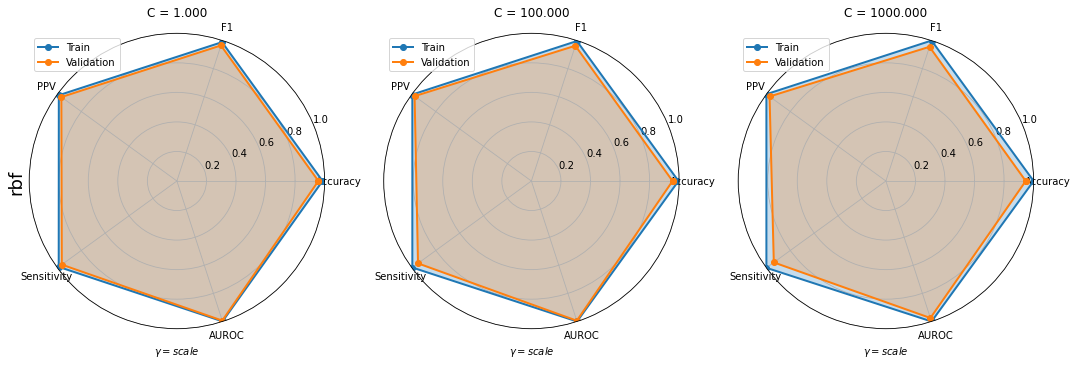

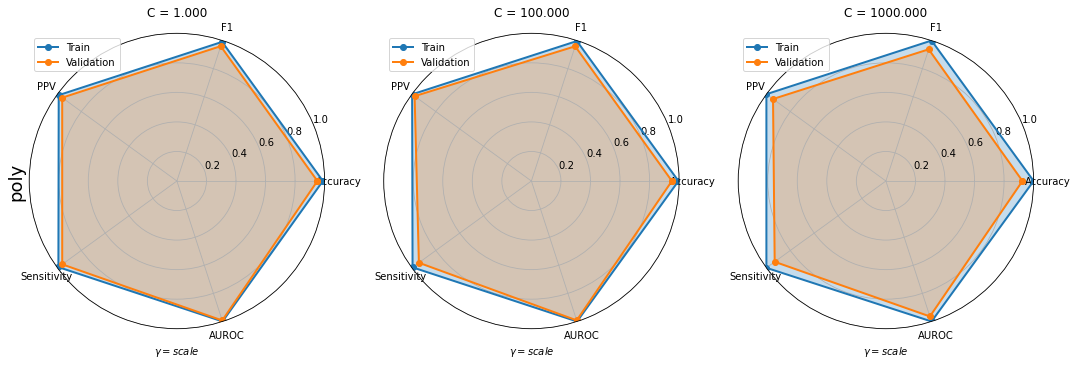

In [151]:
clf_type = ['rbf', 'scale']
plot_radar(svm_nonlin, clf_type)
clf_type = ['poly', 'scale']
plot_radar(svm_nonlin, clf_type)

In [152]:
calc_TN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 0]
calc_FP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 1]
calc_FN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 0]
calc_TP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 1]

def Evaluation_metrics(x_train,x_test,model,method):
    y_pred_test = model.predict(x_test) #NOTICE NOT TO USE THE STANDARDIZED DATA.
    y_pred_proba_test = model.predict_proba(x_test)
    #--------------------------Impelment your code here:-------------------------------------
#     if method=='log_reg' :
#          LOSS=log_loss(y_test,y_pred_test)
#     else: #lin_SVM/ non-lin_SVM
#         y_pred_test_sc=np.where(y_pred_test==0, -1, y_pred_test)
#         y_test_sc=np.where(y_test==0, -1, y_test)
#         LOSS=hinge_loss(y_test_sc,y_pred_test_sc)

    TN = calc_TN(y_test, y_pred_test)
    TP = calc_TP(y_test, y_pred_test)
    FN = calc_FN(y_test, y_pred_test)
    FP = calc_FP(y_test, y_pred_test)
    Se = TP/(TP+FN)
    Sp = TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    Acc = (TP+TN)/(TP+TN+FP+FN)
    F1 = (2*PPV*Se)/(PPV+Se)
    print(f'Sensitivity is {Se:.2f}')
    print(f'Specificity is {Sp:.2f}')
    print(f'PPV is {PPV:.2f}')
    print(f'NPV is {NPV:.2f}')
    print(f'Accuracy is {Acc:.2f}')
    print(f'F1 is {F1:.2f}')
#     print(f'LOSS is {LOSS:.2f}')
    plot_confusion_matrix(model, x_test, y_test, cmap=plt.cm.Blues)
    plt.grid(False)
    #------------------------------------------------------------------------------------------
    print('AUROC is {:.3f}'.format(roc_auc_score(y_test, y_pred_proba_test[:,1])))

Sensitivity is 0.94
Specificity is 0.84
PPV is 0.90
NPV is 0.90
Accuracy is 0.90
F1 is 0.92
AUROC is 0.961


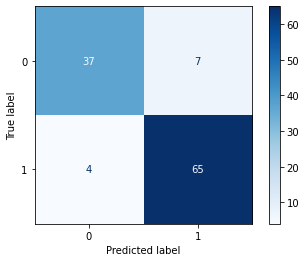

In [153]:
#5b:
#Linear 1
Evaluation_metrics(X_train,X_test,best_svm_lin,method='lin_SVM')

Sensitivity is 0.94
Specificity is 0.84
PPV is 0.90
NPV is 0.90
Accuracy is 0.90
F1 is 0.92
AUROC is 0.963


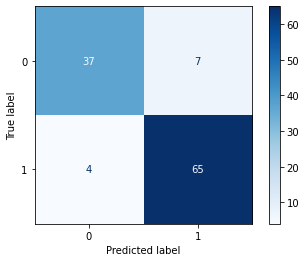

In [154]:
#Linear 2
Evaluation_metrics(X_train_scaled,X_test_scaled,log_reg,'log_reg')

Sensitivity is 0.96
Specificity is 0.91
PPV is 0.94
NPV is 0.93
Accuracy is 0.94
F1 is 0.95
AUROC is 0.976


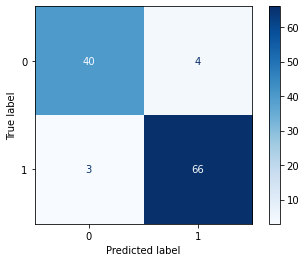

In [155]:
#Non-linear 
Evaluation_metrics(X_train,X_test,best_svm_nonlin,'SVM')

section 6

We now apply random forest classifier to explore the feature importance


Sensitivity is 0.90
Specificity is 0.93
PPV is 0.95
NPV is 0.85
Accuracy is 0.91
F1 is 0.93
AUROC is 0.976


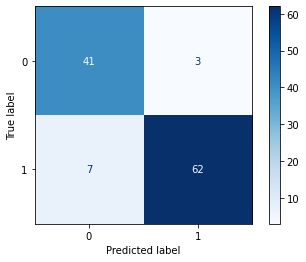

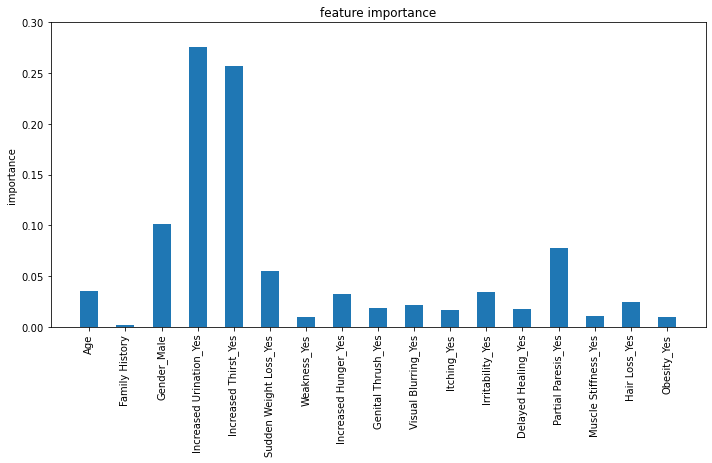

In [156]:
#section 6-random forest
rfc = Pipeline(steps=[('scale', StandardScaler()), ('RFC', RandomForestClassifier(max_depth=4, random_state=0, criterion='gini'))])
rfc.fit(X_train, y_train)
Evaluation_metrics(X_train, X_test, rfc,'rf')

#feature importance
importance = rfc.named_steps["RFC"].feature_importances_
features=X_train.columns.values
x = np.arange(len(features))
width = 0.5  # the width of the bars
fig, axs = plt.subplots(figsize=(10,5))
axs.bar(x, importance, width)
axs.set(xticks=x, xticklabels=features, ylabel='importance', title='feature importance')
fig.tight_layout()
plt.ylim(0,0.3)
plt.xticks(rotation=90)
plt.show()


6.a.i As can be seen from the bar plot above, whoch presents the features importance from the random forest classifier, the two most important features are the "Increased Urination" and the "Increased Thirst"

6.a.ii This result does indeed match with the features exploration we did previously. From the barplots exploring each feature it can be clearly noticed that in these two features, the YES answers were mainly governed by Positive labels and very few Negatives, while the NO answers were mainly governed by Negative labels with very few Positives.

section 7:

Before aplying PCA, data should be centered around zero. Therefore, we first scale the data, then perform dimensionality reduction to 2 Principle Components:

In [181]:
#7a-

#scaling
scale=StandardScaler()

X_train_scaled=scale.fit_transform(X_train)
X_test_scaled=scale.transform(X_test)


n_components = 2
pca=PCA(n_components,whiten=True)
X_train_pca=pca.fit_transform(X_train_scaled)
X_test_pca=pca.transform(X_test_scaled)

In [182]:
def plt_2d_pca(X_pca,y):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, aspect='equal')
    ax.scatter(X_pca[y==0, 0], X_pca[y==0, 1], color='b')
    ax.scatter(X_pca[y==1, 0], X_pca[y==1, 1], color='r')
    ax.legend(('Negative','Positive'))
    ax.plot([0], [0], "ko")
    ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
    ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
    ax.set_xlabel('$U_1$')
    ax.set_ylabel('$U_2$')
    ax.set_title('2D PCA')

7(a) Now, plotting the data with 2d plots, based on the 2 prinicple components we found:

Text(0.5, 1.0, '2D PCA - test')

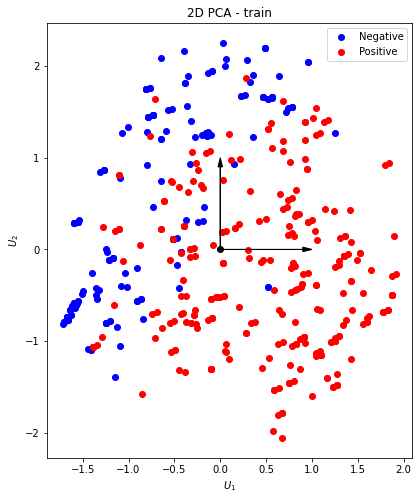

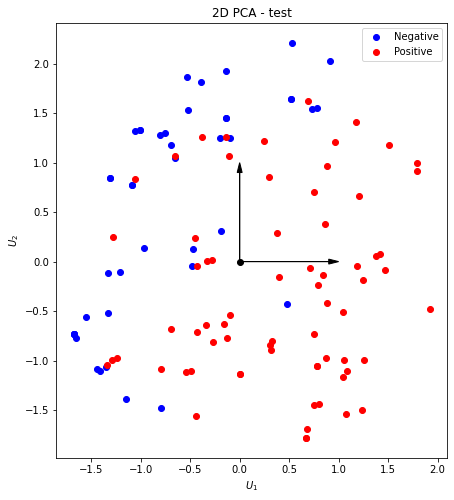

In [183]:
#train set
plt_2d_pca(X_train_pca,y_train)
plt.title('2D PCA - train')

#test set
plt_2d_pca(X_test_pca,y_test)
plt.title('2D PCA - test')

7(b) As can be seen in the plots above, when reduced to two features, data is seperable, though not perfectly seperable. It is possible to find a line that seperates the Negative from Positive! However, since data is not completely seperable, and there is some overlap between the two labels, , it will still result in misdetections.

7(c) We now train the dimensionality-reduced data on the models above (linear and non-linear). 
Since linear SVM previously gave better results than Logistic Regression, we will use linear SVM as the linear model

In [184]:
#7c

# Model 1 - SVM
svm_lin_pca = SVM_lin_model(X_train_pca, y_train)
best_svm_lin_pca = svm_lin_pca.best_estimator_
print(svm_lin_pca.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END svm__C=0.001, svm__kernel=linear; accuracy: (train=0.607, test=0.604) f1: (train=0.755, test=0.753) precision: (train=0.607, test=0.604) recall: (train=1.000, test=1.000) roc_auc: (train=0.935, test=0.895) total time=   0.0s
[CV 2/5] END svm__C=0.001, svm__kernel=linear; accuracy: (train=0.607, test=0.604) f1: (train=0.755, test=0.753) precision: (train=0.607, test=0.604) recall: (train=1.000, test=1.000) roc_auc: (train=0.925, test=0.969) total time=   0.0s
[CV 3/5] END svm__C=0.001, svm__kernel=linear; accuracy: (train=0.608, test=0.600) f1: (train=0.756, test=0.750) precision: (train=0.608, test=0.600) recall: (train=1.000, test=1.000) roc_auc: (train=0.946, test=0.887) total time=   0.0s
[CV 4/5] END svm__C=0.001, svm__kernel=linear; accuracy: (train=0.605, test=0.611) f1: (train=0.754, test=0.759) precision: (train=0.605, test=0.611) recall: (train=1.000, test=1.000) roc_auc: (train=0.932, test=0.941) total t

In [185]:
# non-linear model SVM
svm_nonlin_pca = SVM_nonlin_model(X_train_pca, y_train)
best_svm_nonlin_pca = svm_nonlin_pca.best_estimator_
print(svm_nonlin_pca.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END svm__C=1, svm__gamma=auto, svm__kernel=rbf; accuracy: (train=0.911, test=0.912) f1: (train=0.927, test=0.926) precision: (train=0.923, test=0.943) recall: (train=0.932, test=0.909) roc_auc: (train=0.950, test=0.952) total time=   0.0s
[CV 2/5] END svm__C=1, svm__gamma=auto, svm__kernel=rbf; accuracy: (train=0.898, test=0.934) f1: (train=0.916, test=0.945) precision: (train=0.914, test=0.945) recall: (train=0.918, test=0.945) roc_auc: (train=0.944, test=0.967) total time=   0.0s
[CV 3/5] END svm__C=1, svm__gamma=auto, svm__kernel=rbf; accuracy: (train=0.923, test=0.822) f1: (train=0.935, test=0.857) precision: (train=0.957, test=0.828) recall: (train=0.914, test=0.889) roc_auc: (train=0.966, test=0.881) total time=   0.0s
[CV 4/5] END svm__C=1, svm__gamma=auto, svm__kernel=rbf; accuracy: (train=0.901, test=0.922) f1: (train=0.917, test=0.936) precision: (train=0.922, test=0.944) recall: (train=0.913, test=0.927) r

Evaluation parameters:

Sensitivity is 0.84
Specificity is 0.84
PPV is 0.89
NPV is 0.77
Accuracy is 0.84
F1 is 0.87
AUROC is 0.916


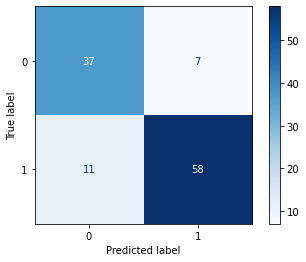

In [173]:
# Linear 
Evaluation_metrics(X_train_pca,X_test_pca,best_svm_lin_pca,method='lin_SVM')

Sensitivity is 0.86
Specificity is 0.84
PPV is 0.89
NPV is 0.79
Accuracy is 0.85
F1 is 0.87
AUROC is 0.929


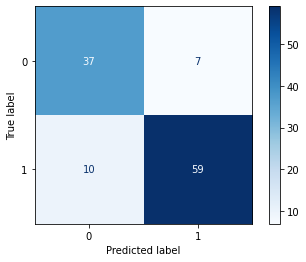

In [186]:
# Non-linear
Evaluation_metrics(X_train_pca,X_test_pca,best_svm_nonlin_pca,'SVM')

7(d) We now train the models above on the best 2 features from section 6 (as derived from Random Forest Classifier). Again, we test a linear SVM model, and non-linears SVM models:

In [187]:
best_2_X_train = X_train[['Increased Urination_Yes', 'Increased Thirst_Yes']]
best_2_X_test = X_test[['Increased Urination_Yes', 'Increased Thirst_Yes']]

# Model 1 - SVM
svm_lin_2 = SVM_lin_model(best_2_X_train, y_train)
best_svm_lin_2 = svm_lin_2.best_estimator_
print(svm_lin_2.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END svm__C=0.001, svm__kernel=linear; accuracy: (train=0.607, test=0.604) f1: (train=0.755, test=0.753) precision: (train=0.607, test=0.604) recall: (train=1.000, test=1.000) roc_auc: (train=0.910, test=0.889) total time=   0.0s
[CV 2/5] END svm__C=0.001, svm__kernel=linear; accuracy: (train=0.607, test=0.604) f1: (train=0.755, test=0.753) precision: (train=0.607, test=0.604) recall: (train=1.000, test=1.000) roc_auc: (train=0.905, test=0.912) total time=   0.0s
[CV 3/5] END svm__C=0.001, svm__kernel=linear; accuracy: (train=0.608, test=0.600) f1: (train=0.756, test=0.750) precision: (train=0.608, test=0.600) recall: (train=1.000, test=1.000) roc_auc: (train=0.915, test=0.852) total time=   0.0s
[CV 4/5] END svm__C=0.001, svm__kernel=linear; accuracy: (train=0.605, test=0.611) f1: (train=0.754, test=0.759) precision: (train=0.605, test=0.611) recall: (train=1.000, test=1.000) roc_auc: (train=0.896, test=0.943) total t

In [188]:
# non-linear model SVM
svm_nonlin_2 = SVM_nonlin_model(best_2_X_train, y_train)
best_svm_nonlin_2 = svm_nonlin_2.best_estimator_
print(svm_nonlin_2.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END svm__C=1, svm__gamma=auto, svm__kernel=rbf; accuracy: (train=0.867, test=0.857) f1: (train=0.887, test=0.876) precision: (train=0.913, test=0.920) recall: (train=0.863, test=0.836) roc_auc: (train=0.826, test=0.836) total time=   0.0s
[CV 2/5] END svm__C=1, svm__gamma=auto, svm__kernel=rbf; accuracy: (train=0.859, test=0.890) f1: (train=0.881, test=0.902) precision: (train=0.900, test=0.979) recall: (train=0.863, test=0.836) roc_auc: (train=0.811, test=0.897) total time=   0.0s
[CV 3/5] END svm__C=1, svm__gamma=auto, svm__kernel=rbf; accuracy: (train=0.876, test=0.822) f1: (train=0.895, test=0.846) precision: (train=0.923, test=0.880) recall: (train=0.868, test=0.815) roc_auc: (train=0.911, test=0.886) total time=   0.0s
[CV 4/5] END svm__C=1, svm__gamma=auto, svm__kernel=rbf; accuracy: (train=0.854, test=0.911) f1: (train=0.875, test=0.926) precision: (train=0.907, test=0.943) recall: (train=0.845, test=0.909) r

Evalutaion Parameters:

Sensitivity is 0.86
Specificity is 0.86
PPV is 0.91
NPV is 0.79
Accuracy is 0.86
F1 is 0.88
AUROC is 0.895


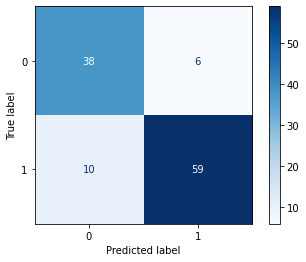

In [190]:
#Linear model
Evaluation_metrics(best_2_X_train,best_2_X_test,best_svm_lin_2,method='lin_SVM')

Sensitivity is 0.86
Specificity is 0.86
PPV is 0.91
NPV is 0.79
Accuracy is 0.86
F1 is 0.88
AUROC is 0.895


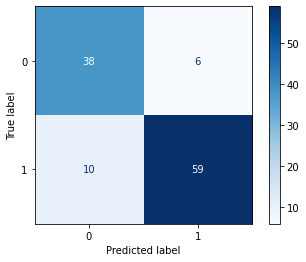

In [191]:
#non-linear models
Evaluation_metrics(best_2_X_train,best_2_X_test,best_svm_nonlin_2,'SVM')

7(e)
Theoratically speaking, we would expect to get better results for the reduced dimentionality, compared to best 2 features. Because in PCA, we find the two orthogonal vectors that carries the most information of the data, and are a linear combination of *all features*. While best 2 features is in some way a special case of the PCA, where the vectors are 2 features. Therefore, we would expect to have similar or better results for the dimensionality reduction. 
In our case, it is a bit tricky. Generally, PCA should be performed on a contineuos data and not binary data. The resoan is that the algorithm seeks to maximize the variance. And the variance of a binary data is not as meaningful.
Our data is mostly consisted of binary data, with an additional feature that is contineous, i.e. the Age. This additional feature does add some distribution to the data and adds variance. However, since the data is mostly binary, using PCA is a bit problematic.
Looking at our results, we can see that in terms of Sensitivity, Specificity, PPV, NPV, Accuracy and F1, the best 2 features performed better. In terms of AUROC, the PCA performed better. So in total, results are a bit ambigeous, as expected.
